In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold

import torch
from torchtext.datasets import AG_NEWS, IMDB

import flair
flair.device = torch.device('cpu')
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
import numpy as np

from data.autoencoding_dataset import AutoencodingDataset
from autoencoders.autoencoder import Autoencoder

import umap

# Prepare Dataset

In [2]:
def prepare_dataset(dataset=AG_NEWS(split='test'), max_len=16):
    dr = list(dataset)
    sentences = [d[1] for d in dr]
    classes = [d[0] for d in dr]
    dp = AutoencodingDataset(sentences, classes=classes, max_len=max_len)
    dp.preproces()
    return dp

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(


# Prepare Embeddings

In [3]:
def prepare_embeddings(encoders,
                       dataset,
                       sample_size=2500,
                       bow=True,
                       sow=True):
    # Additional Encoders
    if bow:
        encoders['bow'] = (lambda x: x.mean(1))
    if sow:
        encoders['sow'] = (lambda x: x)
    
    dl = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Preparation of the Embeddings
    print("Preparing embeddings...")
    embeddings = {k: [] for k in encoders.keys()}
    target = []
    for _, (x,y) in zip(trange(sample_size), dl):
        for k, v in embeddings.items():
            v.append(encoders[k](x).data.numpy().reshape(-1))
        target.append(y[0])#.item())
        
    for k, v in embeddings.items():
        embeddings[k] = np.array(v)
    target = (np.array(target) == np.unique(target).reshape(-1,1)).argmax(0)
    
    return embeddings, target 

# Load Encoder

In [4]:
def load_encoder(path, contains_loss=False, n_layers=3,variational=False):
    m = Autoencoder(100,100,100,4,n_layers,variational=variational, max_log2len=8)
    loaded = torch.load(path, map_location=torch.device('cpu'))
    if contains_loss: 
        if type(loaded[1]) in [dict, tuple]:
            loaded = loaded[0]
        else:
            loaded = loaded[1]

    m.load_state_dict(loaded)
    encoder = m.encoder
    return encoder

# AG_NEWS

In [5]:
ds = prepare_dataset()

Preparing sentences...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:12<00:00, 628.78it/s]


Making sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:03<00:00, 2279.83it/s]


Embedding sentences...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7600/7600 [00:01<00:00, 4092.03it/s]


Splitting sentences...


7600it [00:00, 45241.31it/s]

Done!


In [9]:
vae_encoder = load_encoder('models/ag_news/vae_epoch24.zip')
dae_encoder = load_encoder('models/ag_news/AG_NEWS_DAE_big_12epoch_new.pt', True)
vanilla_encoder = load_encoder('models/ag_news/vainlla.zip')
vae_small_encoder = load_encoder('models/ag_news/vae_small_9_AG.pt', True, 1)
dae_small_encoder = load_encoder('models/ag_news/dae_small_9_AG.pt', True, 1)
vanilla_small_encoder = load_encoder('models/ag_news/vanilla_small_9_AG.pt', True, 1)

In [10]:
X, Y = prepare_embeddings(
    {
        "vae":vae_encoder,
        "dae":dae_encoder,
        "vanilla":vanilla_encoder,
        "vae_small":vae_small_encoder,
        "dae_small":dae_small_encoder,
        "vanilla_small":vanilla_small_encoder
    },
    ds,
    1000
)

Preparing embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.15it/s]


In [18]:
representations = {}
reducer = umap.UMAP(n_neighbors=100)
for k,v in tqdm(X.items()):
    representations[k] = reducer.fit_transform(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.07s/it]


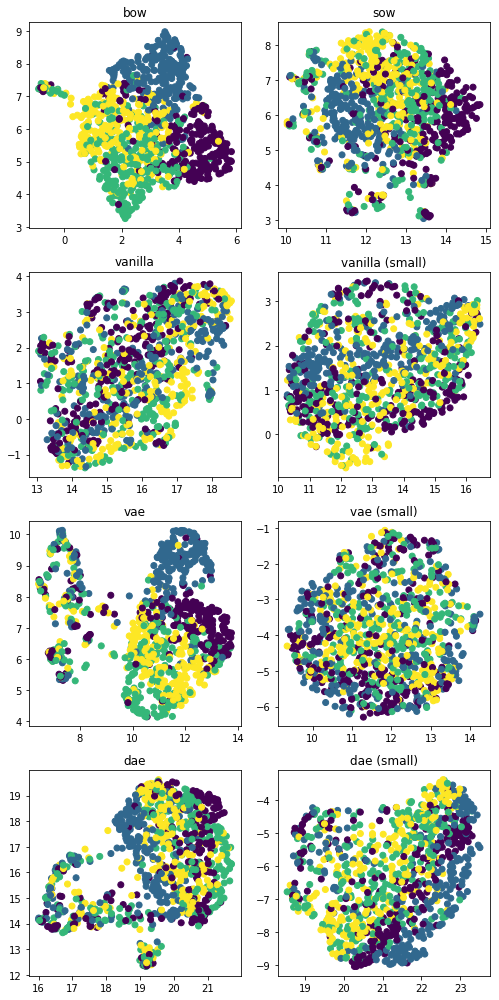

In [19]:
fig, axs = plt.subplots(4, 2, figsize=(7,14))
axs[0][0].scatter(representations['bow'][:,0], representations['bow'][:,1], c=Y, )
axs[0][1].scatter(representations['sow'][:,0], representations['sow'][:,1], c=Y, )
axs[1][0].scatter(representations['vanilla'][:,0], representations['vanilla'][:,1], c=Y, )
axs[2][0].scatter(representations['vae'][:,0], representations['vae'][:,1], c=Y, )
axs[3][0].scatter(representations['dae'][:,0], representations['dae'][:,1], c=Y, )
axs[1][1].scatter(representations['vanilla_small'][:,0], representations['vanilla_small'][:,1], c=Y,)
axs[2][1].scatter(representations['vae_small'][:,0], representations['vae_small'][:,1], c=Y,)
axs[3][1].scatter(representations['dae_small'][:,0], representations['dae_small'][:,1], c=Y,)
axs[0][0].set_title("bow")
axs[0][1].set_title("sow")
axs[1][0].set_title("vanilla")
axs[2][0].set_title("vae")
axs[3][0].set_title("dae")
axs[1][1].set_title("vanilla (small)")
axs[2][1].set_title("vae (small)")
axs[3][1].set_title("dae (small)")
fig.tight_layout()

In [21]:
fig.savefig("AG_EMBEDDINGS_UMAP_SMALL", dpi=300)

# IMDB

In [102]:
ds = prepare_dataset(IMDB(split='test'))

/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/utils/common.py:24: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn(
/home/bodo/.local/lib/python3.8/site-packages/torch/utils/data/datapipes/iter/selecting.py:54: UserWarning: Lambda function is not supported for pickle, please use regular python function or functools.partial instead.
  warnings.warn("Lambda function is not supported for pickle, please use "


Preparing sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:02<00:00, 103.10it/s]


Making sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:21<00:00, 307.60it/s]


Embedding sentences...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 593.99it/s]


Splitting sentences...


25000it [00:02, 8575.32it/s]

Done!


In [107]:
vae_encoder = load_encoder('models/imdb/vae_big_18epoch.pt', True)
dae_encoder = load_encoder('models/imdb/DAE_big_12epoch_new.pt', True)
vanilla_encoder = load_encoder('models/imdb/vanilla_epoch_10.zip')
vae_small_encoder = load_encoder('models/imdb/vae_small_6_IMDB.pt', True, 1)
dae_small_encoder = load_encoder('models/imdb/dae_small_6_IMDB.pt', True, 1)
vanilla_small_encoder = load_encoder('models/imdb/vanilla_small_6_IMDB.pt', True, 1)

In [108]:
X, Y = prepare_embeddings(
    {
        "vae":vae_encoder,
        "dae":dae_encoder,
        "vanilla":vanilla_encoder,
        "vae_small":vae_small_encoder,
        "dae_small":dae_small_encoder,
        "vanilla_small":vanilla_small_encoder
    },
    ds,
    1000
)

Preparing embeddings...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.11it/s]


In [109]:
representations = {}
reducer = umap.UMAP(n_neighbors=15)
for k,v in tqdm(X.items()):
    representations[k] = reducer.fit_transform(v)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:40<00:00,  5.08s/it]


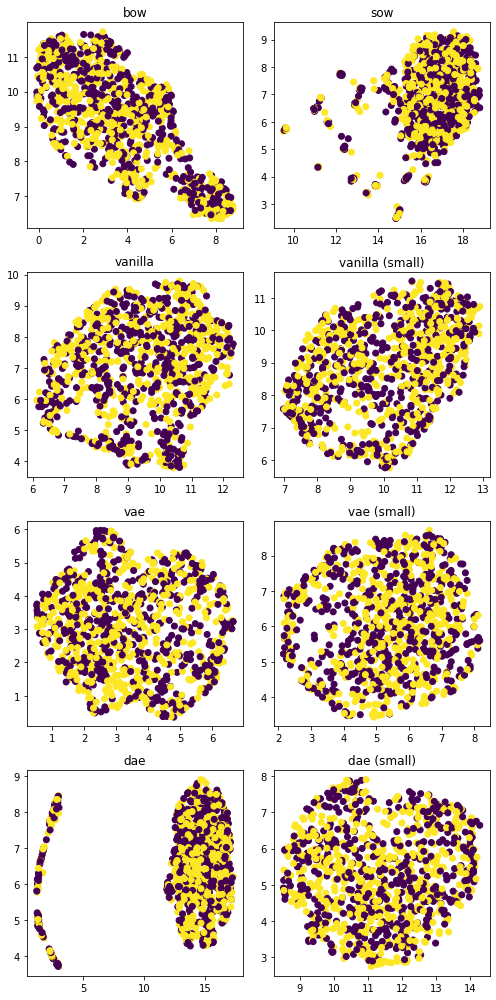

In [113]:
fig, axs = plt.subplots(4, 2, figsize=(7,14))
axs[0][0].scatter(representations['bow'][:,0], representations['bow'][:,1], c=Y, )
axs[0][1].scatter(representations['sow'][:,0], representations['sow'][:,1], c=Y, )
axs[1][0].scatter(representations['vanilla'][:,0], representations['vanilla'][:,1], c=Y, )
axs[2][0].scatter(representations['vae'][:,0], representations['vae'][:,1], c=Y, )
axs[3][0].scatter(representations['dae'][:,0], representations['dae'][:,1], c=Y, )
axs[1][1].scatter(representations['vanilla_small'][:,0], representations['vanilla_small'][:,1], c=Y,)
axs[2][1].scatter(representations['vae_small'][:,0], representations['vae_small'][:,1], c=Y,)
axs[3][1].scatter(representations['dae_small'][:,0], representations['dae_small'][:,1], c=Y,)
axs[0][0].set_title("bow")
axs[0][1].set_title("sow")
axs[1][0].set_title("vanilla")
axs[2][0].set_title("vae")
axs[3][0].set_title("dae")
axs[1][1].set_title("vanilla (small)")
axs[2][1].set_title("vae (small)")
axs[3][1].set_title("dae (small)")
fig.tight_layout()

In [114]:
fig.savefig("IMDB_EMBEDDINGS_UMAP_SMALL", dpi=300)